# 03 - Text Preprocessing

This notebook preprocesses the cleaned text data for topic modeling.

## Preprocessing Steps
- Text cleaning (case, punctuation, numbers)
- Tokenization
- Stopword removal (Indonesian + English)
- Stemming with PySastrawi (with performance tracking)
- Bigram/Trigram phrase detection
- Save processed corpus

In [1]:
# Import required libraries
import sys
import time
import pickle
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

# Add project root to path
project_root = Path.cwd().parent
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

from src.config import get_settings, ensure_directories
from src.preprocessor import IndonesianPreprocessor

In [2]:
# Load settings and data
settings = get_settings()
ensure_directories(settings)

data_path = settings.processed_data_dir / settings.clean_metadata_file
print(f"Loading cleaned data from: {data_path}")

df = pd.read_csv(data_path)
print(f"Loaded {len(df):,} records")

Loading cleaned data from: C:\Users\alifn\PycharmProjects\topic-modeling-utama\data\processed\clean_metadata.csv
Loaded 12,077 records


## 1. Initialize Preprocessor

In [3]:
# Configuration
USE_STEMMING = settings.use_stemming
USE_BIGRAMS = settings.use_bigrams
USE_TRIGRAMS = settings.use_trigrams

# Custom stopwords (domain-specific)
CUSTOM_STOPWORDS = {
    # 1. Kata Umum & Kualitatif (General)
    'hal', 'salah', 'memiliki', 'sebesar', 'nilai', 'tingkat',
    'inti', 'jenis', 'makna', 'ditemukan', 'membantu', 'meningkatkan',
    'aspek', 'besar', 'kecil', 'utama', 'unit', 'faktor', 'dimensi',
    'terdaftar', 'orang', 'pihak', 'objek', 'tempat', 'hasil', 'jumlah',
    'responden', 'masyarakat', 'pengguna', 'nasabah', 'klien',
    'bisnis', 'usaha', 'industri', 'implementasi', 'analisa',
    'studi', 'kasus', 'positif', 'negatif',

    # 2. Statistik & Judul (Statistical Terms) - WAJIB HAPUS
    'pengaruh', 'berpengaruh', 'signifikan', 'berpengaruh_signifikan',
    'variabel', 'variabel_independen', 'variabel_dependen',
    'parsial', 'simultan', 'uji', 'sampel', 'populasi', 'hipotesis', 'hipotesa',
    'menunjukan', 'hubungan', 'perbedaan', 'diterima', 'ditolak',
    'deskriptif', 'periode', 'data', 'rata_rata', 'koefisien',

    # 3. Akademik & Metodologi (Academic Boilerplate)
    'penulis', 'tujuan', 'teori', 'skripsi', 'berjudul', 'menganalisis',
    'studi', 'program_studi', 'universitas', 'perguruan', 'mahasiswa',
    'metode', 'teknik', 'proses', 'prosedur', 'pelaksanaan', 'penerapan',
    'kegiatan', 'pengelolaan', 'perhitungan', 'penilaian', 'evaluasi',
    'laporan', 'pencatatan', 'penelitian',
    'latar', 'belakang', 'masalah', 'rumusan', 'pustaka', 'tinjauan',
    'kerangka', 'berfikir', 'pemikiran', 'pengujian', 'ratio', 'rasio',
    'manajemen', 'akuntansi',

    # 4. Lokasi, Waktu & Entitas (Location, Time & Entities)
    'tbk', 'persero', 'pt', 'cv', 'jalan', 'perusahaan', 'tahun',
    'indonesia', 'jawa', 'barat', 'timur', 'selatan', 'utara', 'pusat',
    'daerah', 'kabupaten', 'kota', 'provinsi', 'wilayah', 'kecamatan',
    'bandung', 'cimahi', 'jakarta', 'widyatama',

    # 6. Bahasa Inggris (English Leaks)
    'research', 'company', 'test', 'using', 'value', 'influence',
    'analysis', 'based', 'performance', 'method', 'study', 'product',
    'process', 'service', 'management', 'system', 'abstract', 'used',
    'effect', 'quality',
}
print(f"Configuration:")
print(f"  Stemming: {USE_STEMMING}")
print(f"  Bigrams: {USE_BIGRAMS}")
print(f"  Trigrams: {USE_TRIGRAMS}")
print(f"  Custom stopwords: {len(CUSTOM_STOPWORDS)}")

Configuration:
  Stemming: False
  Bigrams: True
  Trigrams: False
  Custom stopwords: 146


In [4]:
# Initialize preprocessor
preprocessor = IndonesianPreprocessor(
    settings=settings,
    custom_stopwords=CUSTOM_STOPWORDS,
    use_stemming=USE_STEMMING,
    use_bigrams=USE_BIGRAMS,
    use_trigrams=USE_TRIGRAMS,
)

print(f"Total stopwords: {len(preprocessor.stopwords)}")

INFO:src.preprocessor:Built stopwords set with 1512 words
INFO:src.preprocessor:Preprocessor initialized (stemming=False)


Total stopwords: 1512


## 2. Test Preprocessing on Sample

In [5]:
# Test on a sample abstract
sample_idx = df[df['abstract'].str.len() > 200].sample(1).index[0]
sample_text = df.loc[sample_idx, 'abstract']

print("Sample Abstract:")
print("-" * 60)
print(sample_text[:500] + "..." if len(sample_text) > 500 else sample_text)

Sample Abstract:
------------------------------------------------------------
Penelitian ini bertujuan untuk: (1) mengetahui perbandingan hasil dari model Altman Modifikasi, Springate, dan Zmijewski dalam memprediksi financial distress, (2) mengetahui model yang paling akurat untuk memprediksi potensi kebangkrutan pada Perusahaan Retail di Indonesia periode 2015-2018. Data yang digunakan dalam penelitian ini adalah laporan keuangan perusahaan yang dipublikasikan di website Bursa Efek Indonesia (BEI). Metode yang digunakan yaitu deskriptif kuantitatif yang bersifat memband...


In [6]:
# Preprocess sample
start_time = time.time()
sample_tokens = preprocessor.preprocess_text(sample_text, apply_phrases=False)
elapsed = time.time() - start_time

print(f"\nPreprocessed tokens ({len(sample_tokens)} tokens, {elapsed:.3f}s):")
print("-" * 60)
print(sample_tokens[:30])
if len(sample_tokens) > 30:
    print(f"... and {len(sample_tokens) - 30} more")


Preprocessed tokens (59 tokens, 0.002s):
------------------------------------------------------------
['perbandingan', 'model', 'altman', 'modifikasi', 'springate', 'zmijewski', 'memprediksi', 'financial', 'distress', 'model', 'memprediksi', 'potensi', 'kebangkrutan', 'retail', 'keuangan', 'dipublikasikan', 'website', 'bursa', 'efek', 'bei', 'kuantitatif', 'bersifat', 'membandingkan', 'ritel', 'bei', 'pengambilan', 'purposive', 'sampling', 'statistik', 'normalitas']
... and 29 more


## 3. Process All Documents

In [7]:
# Get abstracts
abstracts = df['abstract'].fillna('').tolist()

print(f"Processing {len(abstracts):,} documents...")
print(f"This may take a while, especially with stemming enabled.")
print("-" * 60)

Processing 12,077 documents...
This may take a while, especially with stemming enabled.
------------------------------------------------------------


In [8]:
# Process all documents
start_time = time.time()

processed_docs = preprocessor.preprocess_documents(
    abstracts,
    fit_phrases=USE_BIGRAMS or USE_TRIGRAMS,
    show_progress=True,
)

total_time = time.time() - start_time
print(f"\n✅ Preprocessing complete in {total_time:.1f}s")

INFO:src.preprocessor:Preprocessing 12077 documents...
Preprocessing: 100%|██████████| 12077/12077 [00:14<00:00, 861.43it/s]
INFO:src.preprocessor:Fitting bigram model...
INFO:gensim.models.phrases:collecting all words and their counts
INFO:gensim.models.phrases:PROGRESS: at sentence #0, processed 0 words and 0 word types
INFO:gensim.models.phrases:PROGRESS: at sentence #10000, processed 868088 words and 355635 word types
INFO:gensim.models.phrases:collected 407027 token types (unigram + bigrams) from a corpus of 1039537 words and 11979 sentences
INFO:gensim.models.phrases:merged Phrases<407027 vocab, min_count=20, threshold=10, max_vocab_size=40000000>
INFO:gensim.utils:Phrases lifecycle event {'msg': 'built Phrases<407027 vocab, min_count=20, threshold=10, max_vocab_size=40000000> in 1.06s', 'datetime': '2025-12-13T16:39:58.356125', 'gensim': '4.4.0', 'python': '3.12.10 (tags/v3.12.10:0cc8128, Apr  8 2025, 12:21:36) [MSC v.1943 64 bit (AMD64)]', 'platform': 'Windows-11-10.0.26200-SP0


✅ Preprocessing complete in 16.2s


In [9]:
# Display statistics
stats = preprocessor.stats

print("\nPreprocessing Statistics:")
print("=" * 50)
print(f"Total documents:      {stats.total_documents:,}")
print(f"Processed documents:  {stats.processed_documents:,}")
print(f"Skipped documents:    {stats.skipped_documents:,}")
print(f"Total tokens:         {stats.total_tokens:,}")
print(f"Unique tokens:        {stats.unique_tokens:,}")
print(f"Avg tokens/doc:       {stats.avg_tokens_per_doc:.1f}")
print(f"Total time:           {stats.total_time_seconds:.1f}s")
if stats.stemming_time_seconds > 0:
    print(f"Stemming time:        {stats.stemming_time_seconds:.1f}s ({stats.stemming_time_seconds/stats.total_time_seconds*100:.1f}%)")


Preprocessing Statistics:
Total documents:      12,077
Processed documents:  11,979
Skipped documents:    98
Total tokens:         861,113
Unique tokens:        35,643
Avg tokens/doc:       71.9
Total time:           16.2s


## 4. Analyze Processed Corpus

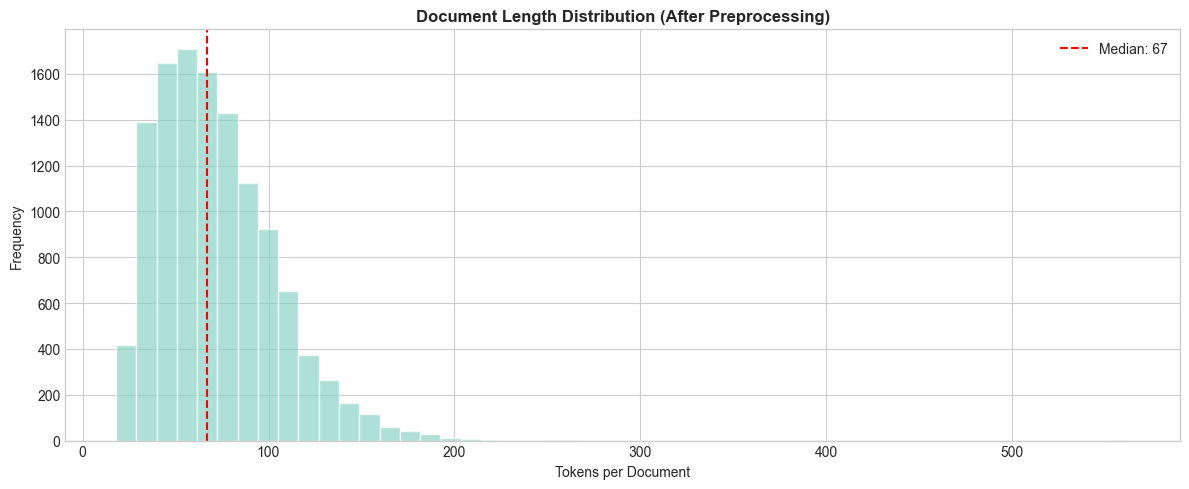

In [10]:
# Token length distribution
token_counts = [len(doc) for doc in processed_docs]

fig, ax = plt.subplots(figsize=(12, 5))
ax.hist(token_counts, bins=50, edgecolor='white', alpha=0.7)
ax.axvline(np.median(token_counts), color='red', linestyle='--',
           label=f'Median: {np.median(token_counts):.0f}')
ax.set_xlabel('Tokens per Document')
ax.set_ylabel('Frequency')
ax.set_title('Document Length Distribution (After Preprocessing)', fontweight='bold')
ax.legend()
plt.tight_layout()
plt.show()

In [11]:
# Top tokens after preprocessing
all_tokens = [token for doc in processed_docs for token in doc]
token_freq = Counter(all_tokens)

print(f"\nTop 50 tokens after preprocessing:")
print("-" * 50)
for token, count in token_freq.most_common(50):
    print(f"  {count:6d}: {token}")


Top 50 tokens after preprocessing:
--------------------------------------------------
    7314: keuangan
    6841: karyawan
    6171: kinerja
    4730: sistem
    3906: konsumen
    3821: produk
    3638: penjualan
    3313: kualitas
    3289: kinerja_karyawan
    3197: informasi
    3084: pajak
    2808: biaya
    2611: kerja
    2605: pemerintah
    2321: bank
    2301: produksi
    2295: pegawai
    2229: jasa
    2212: keputusan_pembelian
    2048: audit_internal
    1955: harga_saham
    1941: profitabilitas
    1931: bursa_efek
    1925: pengendalian
    1896: sesuai
    1881: kualitas_pelayanan
    1868: sistem_informasi
    1835: pengendalian_internal
    1804: laba
    1750: audit
    1741: aktivitas
    1730: internal
    1729: pelayanan
    1719: independen
    1691: harga
    1683: mempengaruhi
    1668: aplikasi
    1638: sumber_daya
    1630: manusia
    1529: disiplin_kerja
    1528: model
    1518: efektivitas
    1507: wajib_pajak
    1494: statistik
    1462: disimpu

In [12]:
# Check for bigrams/trigrams
phrases = [t for t in token_freq if '_' in t]
print(f"\nDetected phrases (bigrams/trigrams): {len(phrases)}")

if phrases:
    print("\nTop 20 phrases:")
    phrase_counts = {p: token_freq[p] for p in phrases}
    for phrase, count in sorted(phrase_counts.items(), key=lambda x: -x[1])[:20]:
        print(f"  {count:5d}: {phrase}")


Detected phrases (bigrams/trigrams): 1882

Top 20 phrases:
   3289: kinerja_karyawan
   2212: keputusan_pembelian
   2048: audit_internal
   1955: harga_saham
   1931: bursa_efek
   1881: kualitas_pelayanan
   1868: sistem_informasi
   1835: pengendalian_internal
   1638: sumber_daya
   1529: disiplin_kerja
   1507: wajib_pajak
   1376: motivasi_kerja
   1241: gaya_kepemimpinan
   1223: kepatuhan_wajib
   1094: regresi_linear
   1092: kualitas_produk
   1025: penerimaan_pajak
   1019: sisa_dipengaruhi
   1009: good_corporate
    984: lingkungan_kerja


## 5. Create DataFrame with Tokens

In [13]:
# Filter original dataframe to match processed documents
# (some documents may have been skipped due to short length)

# Find valid indices
valid_indices = []
doc_idx = 0

for i, abstract in enumerate(abstracts):
    tokens = preprocessor.preprocess_text(abstract, apply_phrases=False)
    if len(tokens) >= settings.min_doc_length:
        valid_indices.append(i)

# Create result dataframe
df_processed = df.iloc[valid_indices].copy().reset_index(drop=True)
df_processed['tokens'] = processed_docs
df_processed['token_count'] = [len(doc) for doc in processed_docs]

print(f"Processed dataframe: {len(df_processed):,} records")

Processed dataframe: 11,979 records


In [14]:
# Preview
df_processed[['title', 'token_count', 'tokens']].head()

,title,token_count,tokens
0,PENGARUH BUDAYA KESELAMATAN DAN KESEHATAN KERJ...,79,"[budaya, keselamatan_kesehatan, kerja, produkt..."
1,Pengaruh Kompensasi terhadap Motivasi Kerja Ka...,89,"[disusun, andri, tanjung, nrp, judul, kompensa..."
2,PERANAN SISTEM INFORMASI AKUNTANSI DALAM MENUN...,155,"[organisasi, didirikan, mencapai, mencari, lab..."
3,PENGARUH USIA DAN MASA KERJA TERHADAP PRODUKTI...,57,"[usia, kerja, produktivitas, pegawai, packer, ..."
4,PENGARUH SISTEM PENGENDALIAN INTERNAL PEMERINT...,50,"[sistem, pengendalian_internal, pemerintah, ku..."


## 6. Save Processed Data

In [15]:
# Save processed corpus
corpus_path = settings.processed_data_dir / settings.processed_corpus_file

corpus_data = {
    'documents': processed_docs,
    'dataframe': df_processed,
    'stats': preprocessor.stats,
}

with open(corpus_path, 'wb') as f:
    pickle.dump(corpus_data, f)

print(f"✅ Saved processed corpus to: {corpus_path}")

✅ Saved processed corpus to: C:\Users\alifn\PycharmProjects\topic-modeling-utama\data\processed\processed_corpus.pkl


In [16]:
# Save preprocessor (for consistent preprocessing of new text)
preprocessor_path = settings.processed_data_dir / 'preprocessor.pkl'
preprocessor.save(preprocessor_path)
print(f"✅ Saved preprocessor to: {preprocessor_path}")

INFO:src.preprocessor:Saved preprocessor to C:\Users\alifn\PycharmProjects\topic-modeling-utama\data\processed\preprocessor.pkl


✅ Saved preprocessor to: C:\Users\alifn\PycharmProjects\topic-modeling-utama\data\processed\preprocessor.pkl


In [17]:
# Also save as CSV (without tokens for readability)
csv_path = settings.processed_data_dir / 'processed_metadata.csv'
df_processed.drop(columns=['tokens']).to_csv(csv_path, index=False)
print(f"✅ Saved metadata CSV to: {csv_path}")

✅ Saved metadata CSV to: C:\Users\alifn\PycharmProjects\topic-modeling-utama\data\processed\processed_metadata.csv


## Summary

In [18]:
print("\n" + "=" * 60)
print("PREPROCESSING COMPLETE")
print("=" * 60)
print(f"\n📊 Documents processed: {len(processed_docs):,}")
print(f"📝 Unique tokens: {stats.unique_tokens:,}")
print(f"📈 Avg tokens/doc: {stats.avg_tokens_per_doc:.1f}")
print(f"⏱️  Total time: {stats.total_time_seconds:.1f}s")

print(f"\n📁 Output files:")
print(f"   - {corpus_path}")
print(f"   - {preprocessor_path}")
print(f"   - {csv_path}")

print(f"\n👉 Next: Run 04_lda_modeling.ipynb to train the LDA model")


PREPROCESSING COMPLETE

📊 Documents processed: 11,979
📝 Unique tokens: 35,643
📈 Avg tokens/doc: 71.9
⏱️  Total time: 16.2s

📁 Output files:
   - C:\Users\alifn\PycharmProjects\topic-modeling-utama\data\processed\processed_corpus.pkl
   - C:\Users\alifn\PycharmProjects\topic-modeling-utama\data\processed\preprocessor.pkl
   - C:\Users\alifn\PycharmProjects\topic-modeling-utama\data\processed\processed_metadata.csv

👉 Next: Run 04_lda_modeling.ipynb to train the LDA model
